# ND Curve Fitting, Interstitial Fraction Calculation Procedure

In [79]:
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.stats import poisson, norm, chi2, cosine, exponnorm, hypsecant, logistic, genlogistic, dweibull, cauchy, exponweib

# Loading and Binning Data

In [80]:
# load data
# wrap this up!!!!
dframe = pd.read_csv("3d_assay_2.csv", header=0)

# extracting unlabeled data
X = dframe[['Ch1','Ch2','Ch3']].to_numpy()

# To do: create method to run elbow analysis using K means to get number of clusters 
# This code uses the labels/known number of clusters
num_clusters = 8
num_channels = dframe.shape[1]-1
num_points = dframe.shape[0]
dist = cauchy
# To do: create for loop to assign cluster names based off of system used by Kari
cluster_names = []

# Extracting each cluster as a series of 3D points
# Indecies are[column][point], w/ column 0 
cluster0 = np.vstack((dframe[dframe['cluster'] == 0]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 0]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 0]['Ch3'].to_numpy()))   # create numpy array for calculations
cluster100000 = np.vstack((dframe[dframe['cluster'] == 100000]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 100000]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 100000]['Ch3'].to_numpy()))
cluster10000 = np.vstack((dframe[dframe['cluster'] == 10000]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 10000]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 10000]['Ch3'].to_numpy()))
cluster1000 = np.vstack((dframe[dframe['cluster'] == 1000]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 1000]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 1000]['Ch3'].to_numpy()))
cluster11000 = np.vstack((dframe[dframe['cluster'] == 11000]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 11000]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 11000]['Ch3'].to_numpy()))
cluster110000 = np.vstack((dframe[dframe['cluster'] == 110000]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 110000]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 110000]['Ch3'].to_numpy()))
cluster111000 = np.vstack((dframe[dframe['cluster'] == 111000]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 111000]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 111000]['Ch3'].to_numpy()))
cluster101000 = np.vstack((dframe[dframe['cluster'] == 101000]['Ch1'].to_numpy(), dframe[dframe['cluster'] == 101000]['Ch2'].to_numpy() , dframe[dframe['cluster'] == 101000]['Ch3'].to_numpy()))

#labeled data will be stored as clusters vector, with indexing clusters[cluster_index][channel][point]
clusters = [cluster0, cluster100000, cluster10000, cluster1000, cluster110000, cluster11000, cluster101000, cluster111000]
# Secoondary way of storing labeled data, with indexing as clusters[cluster_index][point][channel]
clusters2 = [np.transpose(cluster0), np.transpose(cluster100000), np.transpose(cluster10000), np.transpose(cluster1000), np.transpose(cluster110000), np.transpose(cluster11000), np.transpose(cluster101000), np.transpose(cluster111000)]

In [81]:
def loadLabeledData(file_path, num_clusters, num_channels):
    '''
    Loads labeled data, as formatted by Kari from the file path given. Separates into a list of arrays, each array corresponding to 
    a particular cluster
    
    Input: directory that contains files to be read as a string, number of cluster labels
    Output: two lists, each containing cluster data as numpy arrays, the first indexed as: clusters[cluster number][channel][point] the second
            indexed as clusters[cluster_index][point][channel]
            Both are used in subsequent code to iterate over elements differently 
    '''
    #generating a list of cluster names using the BioRad convention
    names = []
    num_clusters=8
    #Loop counts up in binary, int() drops leading zeros
    for k in range(1,num_clusters): 
        names.append(str(int('{:04b}'.format(k))))
    num_zeros = 6 - len(names[num_clusters-2])
    zeros=''
    for i in range(num_zeros):
        zeros = zeros + '0'
    names = [x+zeros for x in names]
    names = ['0'] + names    
    #Generating a list of Channel labels:
    ch_labels = []
    for c in range(num_channels):
        ch_labels.append('Ch'+str(c+1))
    dframe = pd.read_csv(file_path, header=0)
    clusters = [] # All clusters, points accessed by indexing clusters[cluster index][channel index][point index]
    channels_for_one_cluster = [] # Collects all channels for a single cluster
    for cluster_name in names:
        for channel_name in ch_labels:
            one_channel = dframe[dframe['cluster'] == int(cluster_name)][channel_name].to_numpy()
            channels_for_one_cluster.append(one_channel)
        new_cluster = np.vstack(channels_for_one_cluster)
        channels_for_one_cluster = []
        clusters.append(new_cluster)
    # clusters_other_format is also all clusters, points accessed by indexing clusters[cluster index][channel index][point index]
    clusters_other_format = []
    for cluster in clusters:
        clusters_other_format.append(np.transpose(cluster))
    return clusters, clusters_other_format

In [71]:
clusters, x = loadLabeledData('3d_assay_1.csv', 8,3)

(3, 11492) 0
(3, 2173) 1
(3, 2310) 2
(3, 468) 3
(3, 2061) 4
(3, 430) 5
(3, 446) 6
(3, 75) 7


# Fitting Functions and Tests


In [86]:
def fitCauchy(num_channels, num_clusters, clusters):
    '''
    Input: the number of clusters, the number of channels, and actual cluster dataponts 
           Cluster datapoints are in the format clusters[cluster index][channel index][point index]
    Output: A list of fit objects, indexed as fits[cluster index][channel index]
    '''
    # First, calculate summary statistics (mean, std dev) for each cluster, for each channel, storing in an array
    # Cluster stats stores mean and standard deviation, index as clusterStats[cluster #][channel #][mean, std dev]
    clusterStats = np.zeros((num_clusters,num_channels,2))
    for cluster_index, cluster in enumerate(clusters):
        for channel_index in range(num_channels):    
            clusterStats[cluster_index][channel_index][0], clusterStats[cluster_index][channel_index][1] = cluster[channel_index].mean(), np.std(cluster[channel_index])
    #For each cluster, fit a distribution to each channel, storing each fit in a list of lists
    fits = []  # indexing is: fits[cluster][channel]
    one_channel_fits = [] # Stores a trio of fits, one for each channel 
    # indexing clusters to get correct entry of clusterSumStats
    for cluster_index, cluster in enumerate(clusters): # outer loop does each cluster
        for channel_index in range(num_channels): # Inner loop does each channel
            # Compute bounds for given channel
            mean, std = clusterStats[cluster_index][channel_index][0], clusterStats[cluster_index][channel_index][1]
            bounds = [(mean-mean/2,mean+mean/2), (std-std/2, std+std/2)]
            # Generate fit object for each channel
            fit = stats.fit(cauchy, cluster[channel_index], bounds)
            one_channel_fits.append(fit)
        fits.append(one_channel_fits)
        one_channel_fits = []
    return fits
# Indexing for clusterStats: [cluster][channel][stat]

def fitGeneral_continuous(clusters, num_channels, num_clusters, dist):
    '''
    Same as fitCauchy, but takes an additional parameter, a dist to fit any distribution
    Input: the number of clusters, the number of channels, and actual cluster dataponts 
           Cluster datapoints are in the format clusters[cluster index][channel index][point index]
    Output: A list of fit objects, indexed as fits[cluster index][channel index]
    '''
    # First, calculate summary statistics (mean, std dev) for each cluster, for each channel, storing in an array
    # Cluster stats stores mean and standard deviation, index as clusterStats[cluster #][channel #][mean, std dev]
    clusterStats = np.zeros((num_clusters,num_channels,2))
    for cluster_index, cluster in enumerate(clusters):
        for channel_index in range(num_channels):    
            clusterStats[cluster_index][channel_index][0], clusterStats[cluster_index][channel_index][1] = cluster[channel_index].mean(), np.std(cluster[channel_index])
    #For each cluster, fit a distribution to each channel, storing each fit in a list of lists
    fits = []  # indexing is: fits[cluster][channel]
    one_channel_fits = [] # Stores a trio of fits, one for each channel 
    # indexing clusters to get correct entry of clusterSumStats
    for cluster_index, cluster in enumerate(clusters): # outer loop does each cluster
        for channel_index in range(num_channels): # Inner loop does each channel
            # Compute bounds for given channel
            mean, std = clusterStats[cluster_index][channel_index][0], clusterStats[cluster_index][channel_index][1]
            bounds = [(mean-mean/2,mean+mean/2), (std-std/2, std+std/2)]
            # Generate fit object for each channel
            fit = stats.fit(dist, cluster[channel_index], bounds)
            one_channel_fits.append(fit)
        fits.append(one_channel_fits)
        one_channel_fits = []
    return fits

def oneD_log_likelihood(distribution, values, cont):
    '''
    Input: Frozen distribution, values to fit over as a list or dataframe, boolean to flag if distribution is continuous
    Output: Log likelihood of a given set of values being generated by a distribution
    '''
    ll = 0
    if(cont):
        for i in values: 
            ll+= distribution.logpdf(i)[0]
    else:
        for i in values:
            ll+= math.log(distribution.pmf(i))
    return ll  

def bestFit(clusters, num_channels, num_clusters, distributions):
    '''
    Input: all datapoints, sorted into a list of clusters, format clusters[cluster_index][channe;_index][point_index] number of channels, number of clusters, distributions to test
    Output: logLikelihoods matrix, indexed as logLikelihoods[distribution][cluster][channel]
    '''
    #indexing for logLikelihoods is logLikelihoods[distribution][cluster][channel]
    logLikelihoods_all = np.zeros([len(distributions),num_clusters,num_channels])
    for dist_index, distribution in enumerate(distributions):
        fits = fitGeneral_continuous(clusters, num_channels, num_clusters, distribution)
        for cluster_index in range(num_clusters):
            for channel_index in range(num_channels):
                logLikelihoods_all[dist_index][cluster_index][channel_index] = oneD_log_likelihood(dist(fits[cluster_index][channel_index].params), clusters[cluster_index][channel_index], not dist==poisson)
                #logLikelihoods_all[dist_index][cluster_index][channel_index] = oneD_log_likelihood(fits[cluster_index][channel_index], clusters[cluster_index][channel_index], True)
    return logLikelihoods_all

In [87]:
print(len(clusters))
bestFit(clusters,3,8,[norm,cauchy])

8


array([[[-54069.66344995, -54259.75324289, -45547.53081132],
        [-27151.32110406, -23272.71598348, -17998.28201787],
        [-24239.14200077, -28020.61556716, -20425.39809415],
        [-23095.61716497, -23396.12077817, -32689.5832986 ],
        [-12359.41898754, -11644.80192997,  -8355.67226153],
        [ -9963.85147693, -11511.84747146, -14096.61490647],
        [-10444.56825089,  -8970.24700525, -11994.70188509],
        [ -5333.63086874,  -4965.7425697 ,  -6083.61152607]],

       [[-54016.92907588, -54284.93449242, -45428.5523308 ],
        [-27047.20200828, -23269.08889812, -18019.08620876],
        [-24177.72388331, -27805.10322609, -20424.26885039],
        [-23091.74110636, -23402.51311251, -32275.87931105],
        [-12327.81761504, -11578.04474588,  -8336.73368969],
        [ -9955.06441766, -11391.47176227, -13935.36600274],
        [-10449.82327366,  -8971.49048095, -11928.63494499],
        [ -5267.68953239,  -4982.98399971,  -6050.74806171]]])

fits = fitCauchy(clusters, num_channels, num_clusters)

# Interstitial Fraction Functions and Tests

In [187]:
def IFcalcBounds_numpy(fits, clusters, alpha, channel_number, dist):
    '''
    Uses the probability point function and a probabalistic threshold (alpha) to determine which intensity are unlikely given the fitted distribution
        Inputs: Takes vector of fits, vector of clusters, alpha, number of channels, and distribution name 
        Outputs: Returns bounds, a numpy array, indexed as bounds[cluster][lower (0) or upper (1)][channel]
    '''
    bounds = np.zeros([num_clusters,2,num_channels])
    for cluster_index, cluster in enumerate(clusters):
        for channel_index in range(channel_number):
            # Populates lower bound and upper bound elements of bounds array, respectivly
            bounds[cluster_index][0][channel_index] = dist.ppf(alpha, (fits[cluster_index][channel_index].params))[0]
            bounds[cluster_index][1][channel_index] = dist.ppf(1-alpha, (fits[cluster_index][channel_index].params))[0]
    return bounds

In [260]:
def IFcalcStrict2(bounds, clusters, num_channels):
    '''
    Calculates IF simply and strictly, based on whether or not 
        Inputs: Takes parameters bounds (as returned by function IF calcBounds numpy), cluster, and number of channels 
                Note that clusters must be indexed as clusters[cluster index][point index][channel] to compare all channels at once
        Outputs: returns a list of points (as an array) and the cluster index in the form: [array(ch1,...,chN),clusterIndex]
    '''
    # IF_points stored at [ch1,...,chN, clusterIndex]
    IF_points = [] # all points, list format
    # Iterates through each cluster
    for cluster_index, cluster in enumerate(clusters):
        for point_index in range(len(cluster)):
        # cluster[index] returns a 3D point
        # Check if point is out of range in any dimension by comparing values in all channels of a given point to the upper and lower bounds
        # for all channels. If all elements are true, point is in range
            lower_logical = [cluster[point_index]>bounds[cluster_index][0]]  
            upper_logical = [cluster[point_index]<bounds[cluster_index][1]]
        # If one of the elements in the concatenated array is false, np.all will evaluate to false, in which case the point is interstitial
            if(not np.all(np.concatenate((lower_logical, upper_logical)))):
                IF_points.append([cluster[point_index], cluster_index])
    return IF_points   

In [321]:
# Plotting function, adapted for variable dimension number
    # Each plot visualizes 
def IFplot3D(IF_points, X):
    '''
    Input: IF points, as returned by IFcalcStrict2, all points X
    Output: none, prints plot
    '''
    # Take the interstitial points, and extract coordinates as a list of arrays
    list_of_arrays = [x for x, i in if_points]
    x, y, z = [x[0] for x in list_of_arrays], [x[1] for x in list_of_arrays], [x[2] for x in list_of_arrays]
    points = np.transpose(np.vstack((x,y,z)))
    X = [i for i in X if i not in points]
    x1, y1, z1 = [x[0] for x in X], [x[1] for x in X], [x[2] for x in X]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # Creating plot
    ax.scatter3D(x, y, z, color = "magenta", label="Interstitial")
    ax.scatter3D(x1,y1,z1, color = "blue", label="In range")
    # show plot
    ax.set_xlabel("Channel 1")
    ax.set_ylabel("Channel 2")
    ax.set_zlabel("Channel 3")
    plt.legend(loc="upper right")
    plt.show()
    return


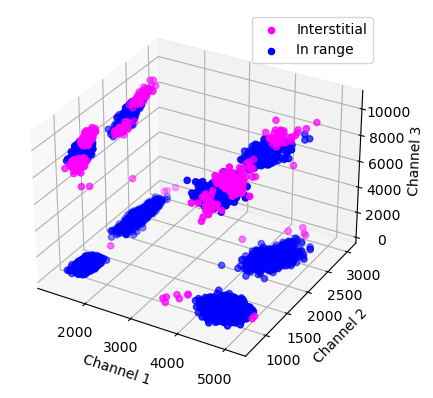

In [335]:
bounds = IFcalcBounds_numpy(fits, clusters, 0.0005, channel_number, dist)
if_points = IFcalcStrict2(bounds, clusters2, num_channels)
IFplot3D(if_points,X)

In [325]:
if_points = [x for x, i in if_points]
x, y, z, = [x[0] for x in if_points],  [x[1] for x in if_points],  [x[2] for x in if_points]